**Poisson equation in 1D with Multi-scale Fourier feature networks**

Retyped by Theodoret Putra Agatho on 7 Aug. 2023

[Source](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/poisson.1d.multiscaleFourier.html)

In [1]:
pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.3 MB/s eta 0:00:00


**Problem setup**

We will solve a Poisson equation:

\begin{align}
        \partial u = -(\pi A)^2 \text{sin} (\pi Ax) - 0.1(\pi B)^2 \text{sin} (\pi Bx), x \in [-1, 1]
    \end{align}

with Dirichlet boundary conditions

\begin{align}
        u(0) = 0, u(1) = 0
    \end{align}

and two user-specified hyper-parameters that implies the fluctuatuion of sine functions

\begin{align}
        A = 2, B = 50
    \end{align}

The exact solution is $u(x) = \text{sin} (\pi Ax) + 0.1 \text{ sin} (\pi Bx)$.

**Implementation**

This description goes through the implementation of a solver for the above described Poisson equation step-by-step. First, the DeepXDE module is imported:

In [2]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf

We begin by defining a computational geometry. We can use a built-in class `Interval` as follows

In [3]:
geom = dde.geometry.Interval(0, 1)

Next, we express the PDE residual of the Poisson equation:

In [4]:
A = 2
B = 50

def pde(x, y):
  dy_xx = dde.grad.hessian(y, x)
  return (
      dy_xx
      + (np.pi * A) ** 2 * tf.sin(np.pi * A * x)
      + 0.1 * (np.pi * B) ** 2 * tf.sin(np.pi * B * x)
  )

The first argument to `pde` is the network input, i.e., the $x$-coordinate. The second argument is the network output, i.e., the solution $u(x)$, but here we use `y` as the name of the variable.

Next, we define a function to return the value of $u(x)$ for the points $x$ on the Dirichlet boundary. In this case, it is $u(x) = 0$.

In [5]:
def func(x):
  return np.sin(np.pi * A * x) + 0.1 * np.sin(np.pi * B * x)

Then, the Dirichlet boundary condition is

In [6]:
bc = dde.icbc.DirichletBC(geom, func, lambda _, on_boundary: on_boundary)

Now, we have specified the geometry, PDE residual and Dirichlet boundary condition. We then define the PDE problem as

In [7]:
data = dde.data.PDE(
    geom,
    pde,
    bc,
    1280,
    2,
    train_distribution="pseudo",
    solution=func,
    num_test=10000,
)

The number 1280 is the number of training residual points sampled inside the domain, and the number 2 is the number of training points sampled on the boundary. The argument `train_distribution = 'pseudo'` means that the sample training points follows a pseudo-random distribution. The argument `solution=func` is the reference solution to compute the error of our solution, and can be ignored if we don't have a reference solution. We use 10000 residual points for testing the PDE residual.

Next, we choose the network. Here, we use a multi-scale Fouriter feature network of depth 4 (i.e., 3 hidden layers) and width 100. `sigmas` is the list of standard deviation of the distribution of fourier feature embeddings. In this example, the network consists of a Fourier feature layer and fully-connected layers. The Fourier feature network is constructed using a random Fourier feature mapping as a coordinate embedding of the inputs. Specificaally, we multiplya the input vector with matrix whose entry is sampled from a Gaussian distribution with mean zero and varience sigma, and then concatenate the list of tensors horizontally with cosine and sine functions. Then, the network is:

In [9]:
layer_size = [1] + [100] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.MsFFN(layer_size, activation, initializer, sigmas=[1, 10])

Now, we have the PDE problem and the network. We build a `Model` and choose the optimizer and learning rate:

In [10]:
model = dde.Model(data, net)
model.compile(
    "adam",
    lr=0.001,
    metrics=["l2 relative error"],
    decay=("inverse time", 2000, 0.9),
)

Compiling model...
Building Multiscale Fourier Feature Network...


/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.133540 s



We also compute the $L^2$ relative error as a metric during training.

We then train the model for 10000 iterations:

In [11]:
losshistory, train_state = model.train(iterations=10000)

Training model...

Step      Train loss              Test loss               Test metric   
0         [3.14e+06, 1.19e-01]    [3.05e+06, 1.19e-01]    [9.85e-01]    
1000      [4.92e+02, 3.94e-01]    [4.85e+02, 3.94e-01]    [5.08e-01]    
2000      [2.02e+01, 1.27e-01]    [3.02e+01, 1.27e-01]    [2.91e-01]    
3000      [1.26e+01, 2.92e-02]    [1.73e+01, 2.92e-02]    [1.42e-01]    
4000      [8.57e+00, 4.91e-03]    [1.12e+01, 4.91e-03]    [6.06e-02]    
5000      [2.19e+01, 6.25e-04]    [2.08e+01, 6.25e-04]    [2.49e-02]    
6000      [2.83e+01, 1.11e-04]    [2.85e+01, 1.11e-04]    [1.26e-02]    
7000      [3.61e+00, 3.57e-05]    [4.64e+00, 3.57e-05]    [8.34e-03]    
8000      [5.40e+00, 2.04e-05]    [6.52e+00, 2.04e-05]    [6.65e-03]    
9000      [2.51e+00, 1.20e-05]    [3.29e+00, 1.20e-05]    [5.41e-03]    
10000     [1.14e+01, 7.98e-06]    [1.23e+01, 7.98e-06]    [4.34e-03]    

Best model at step 9000:
  train loss: 2.51e+00
  test loss: 3.29e+00
  test metric: [5.41e-03]

'train'

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


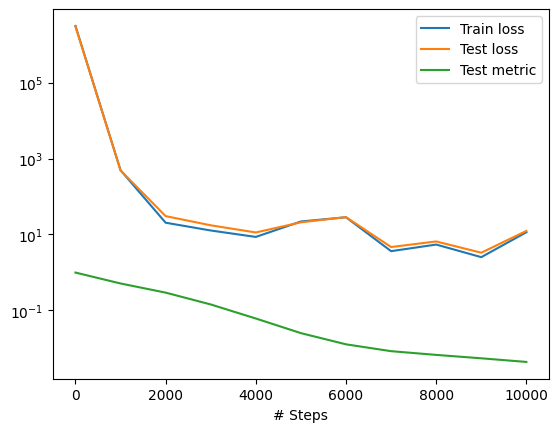

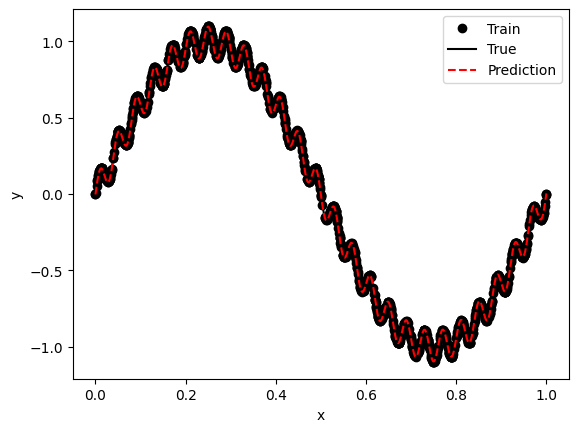

In [12]:
dde.saveplot(model.losshistory, model.train_state, issave=True, isplot=True)